**Author:** Andy Tzanidakis, Neven Caplar and the LINCC Frameworks team \
**Last updated**: November 07, 2024

## Overview

In this notebook we will learn how to:

- Query and filter catalog data
- Compute time-series features for LSDB catalogs using `nested-dask`
- Plot light curves and periodograms

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hats.inspection import plot_pixels
from hats.io.file_io import read_parquet_metadata

# Astropy
from astropy.timeseries import LombScargle

# light-curve package for feature extraction
import light_curve as licu

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.4.2


In [3]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"
gaia_margin_path = f"{catalogs_dir}/gaia_dr3/gaia_10arcs"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf_dr14/ztf_object"
ztf_source_path = f"{catalogs_dir}/ztf_dr14/ztf_source"
ztf_object_margin_path = f"{catalogs_dir}/ztf_dr14/ztf_object_10arcs"

## Initialize Dask Client

Before we start building our workflow, let's initialize our Dask Client. The machine we're using has 16 cores and 64GiB of RAM so we'll decide to make good use of resources and go with 10 workers, each with 6 GiB of memory and 1 thread.

In [4]:
from dask.distributed import Client
client = Client(n_workers=10, memory_limit="6GiB", threads_per_worker=1)

## Get Gaia and ZTF

Let's read Gaia and ZTF (both lazily) as demonstrated in the first notebook.

In [5]:
%%time

# Load Gaia object table (with margins!)
gaia = lsdb.read_hats(gaia_path, columns=['ra', 'dec', 'parallax'], margin_cache=gaia_margin_path)

# Define a cone region of interest for ZTF
cone_search = ConeSearch(ra=132.8460000, dec=+11.8140000, radius_arcsec=5_000)

# Load ZTF object table
ztf = lsdb.read_hats(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'], search_filter=cone_search)

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hats(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], search_filter=cone_search)

CPU times: user 1.75 s, sys: 171 ms, total: 1.92 s
Wall time: 11.5 s


## Create a sample object catalog

To create our sample let's crossmatch our ZTF region with Gaia with a 3-arcsecond radius.

In [6]:
_sample = ztf.crossmatch(gaia, radius_arcsec=3)

We can have a look at the object matches because this sample is relatively small and it fits in memory! 

In [7]:
%%time
_sample_computed = _sample.compute()
_sample_computed

CPU times: user 278 ms, sys: 59 ms, total: 337 ms
Wall time: 3.39 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_healpix_29,,,,,,,
298908806134124139,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
298908810706785769,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
298908811338617360,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445
298920356055544103,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
298920365329078665,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
304104164045541160,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713
304105129564083317,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
304105132512712531,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [8]:
print (f"Number of objects in crossmatch: {len(_sample_computed)}")

Number of objects in crossmatch: 36717


We selected a very small region of the sky - 5000 arcsec - and, as a result, our objects are contained in just a handful of pixels. In the following mollview of the pixel map, the gray color means that our sample catalog does not have coverage for that region in space.

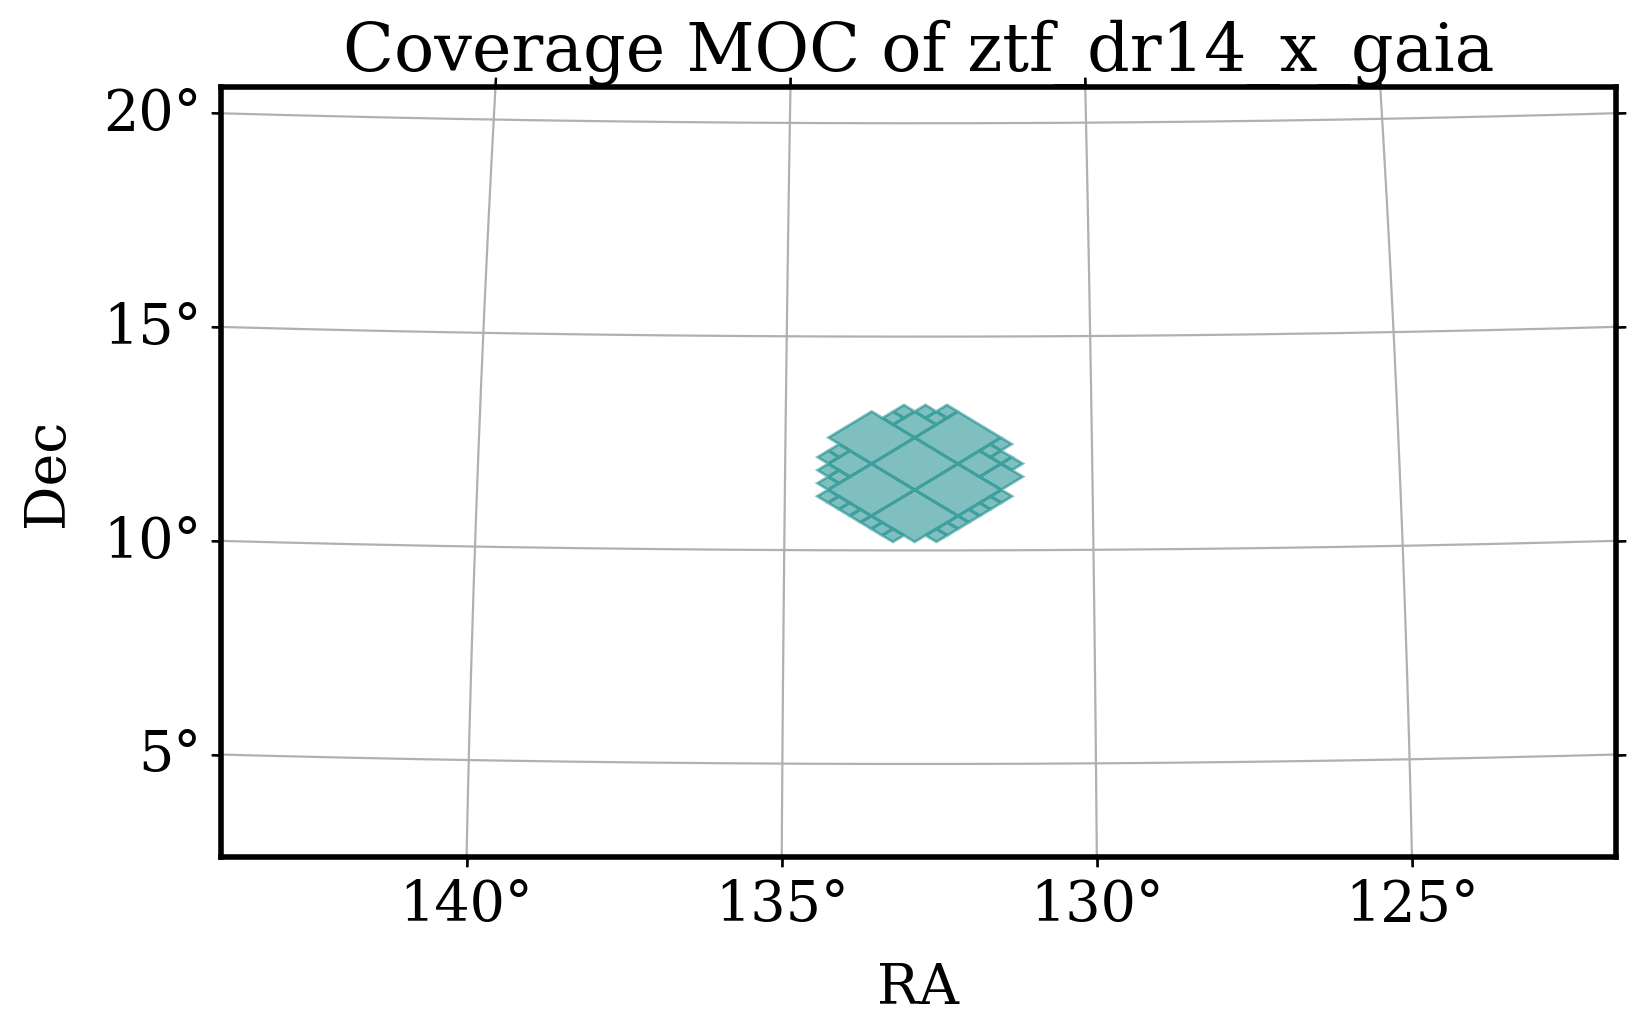

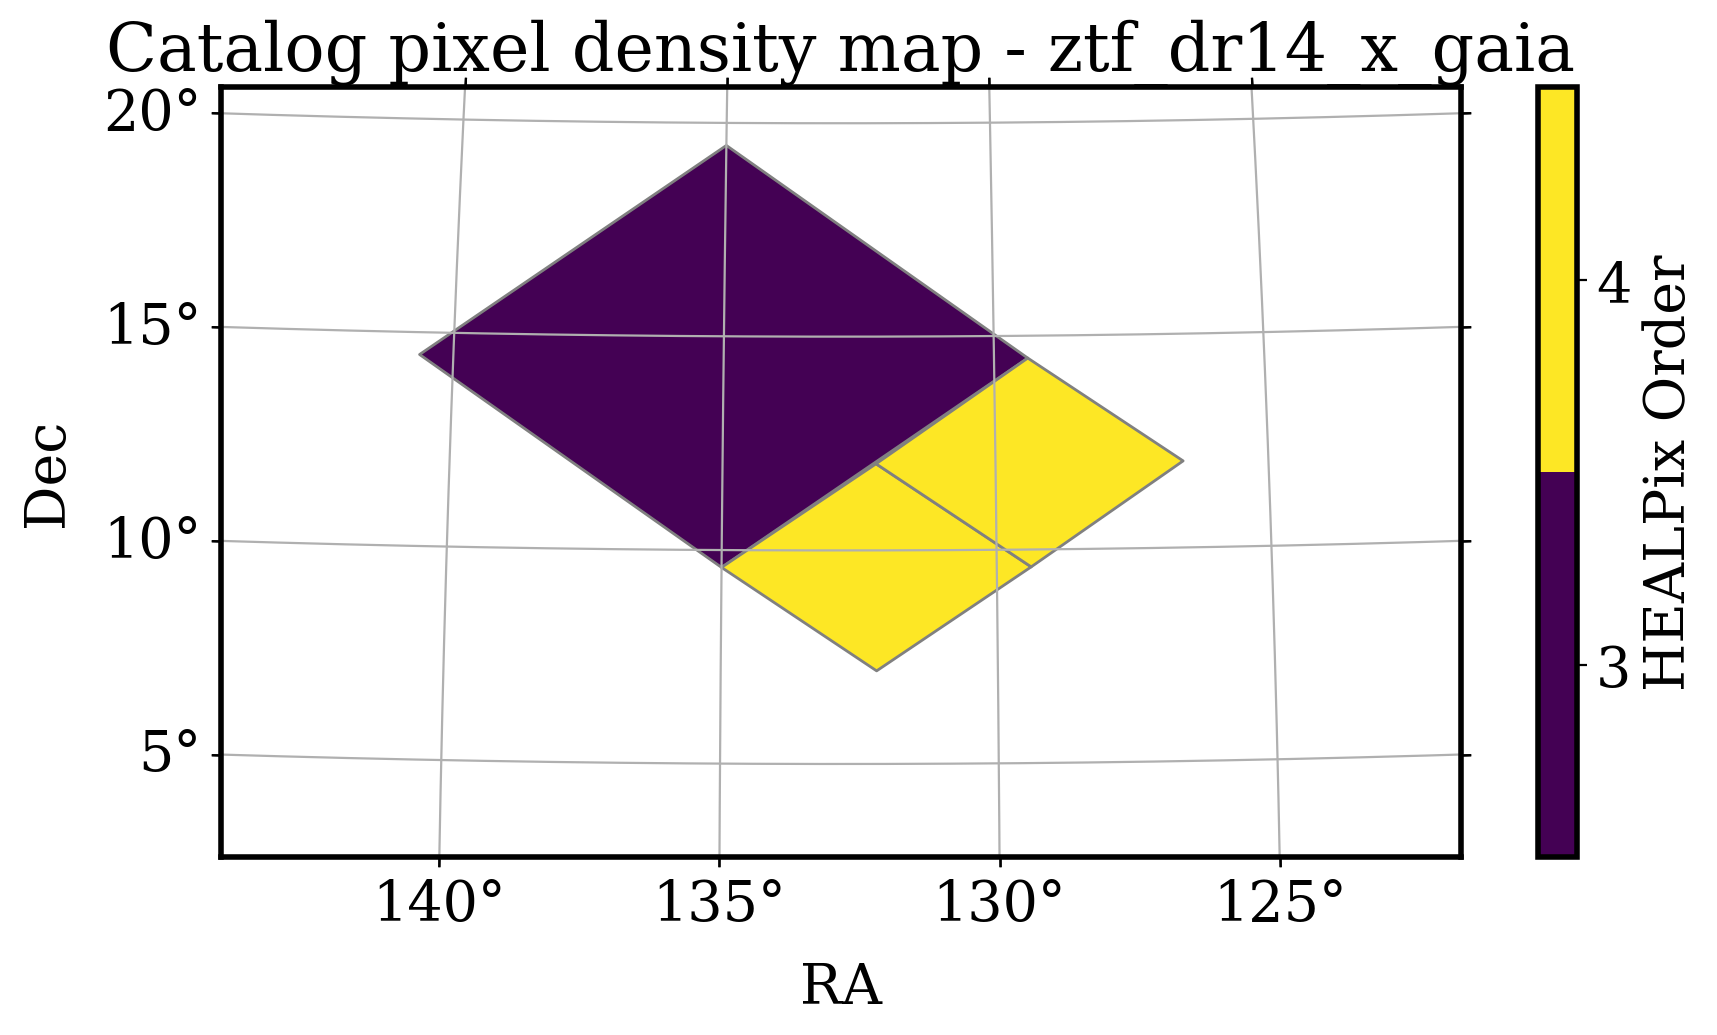

In [9]:
_sample.plot_coverage(
    center=SkyCoord(ra=132.8460000, dec=+11.8140000, unit='deg'),
    fov=(Angle("20deg"), Angle("20deg")),
)
fig, ax = _sample.plot_pixels(
    center=SkyCoord(ra=132.8460000, dec=+11.8140000, unit='deg'),
    fov=(Angle("20deg"), Angle("20deg")),
    edgecolor='grey',
)

## Fetch ZTF light curves for the samples

We will now perform a join operation between our sample objects and their respective ZTF sources. We will use the PanSTARRS object ID, as this is the index that both catalogs share. This is where `nested-dask` features come in handy. Under the hood, this `join_nested` call packs the time-domain data of each object as an additional column, which we decided to conveniently named `sources`.

In [10]:
_sources = _sample.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="sources")
_sources

/opt/conda/envs/notebook/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources
npartitions=6,,,,,,,,
298644950290006016,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [doub..."
299207900243427328,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...,...


Note that we also get a warning stating that we are not using a margin catalog, as previously discussed in the first notebook.

## Filter on r-band

Our workflow will only operate on r-band data. We can apply the necessary cuts to our data to make sure that only light curves that have at least 10 observations in r-band will be considered!

In [11]:
# Query for valid observations in r-band
r_band = _sources.query(
    "sources.band == 'r'"  # r-band only
    " and sources.catflags == 0"  # good observational conditions
    " and sources.mag < 99"  # valid magnitude
    " and 0 < sources.magerr < 99"  # valid magnitude error
)
# Calculate the number of observations
r_band = r_band.reduce(lambda mjd: {"nobs": mjd.size}, "sources.mjd", meta={"nobs": int}, append_columns=True)
r_band = r_band.query("nobs > 10")

In [12]:
r_band

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources,nobs
npartitions=6,,,,,,,,,
298644950290006016,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [doub...",int64
299207900243427328,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...,...,...


In [13]:
%%time
# Cache the data in memory - we will use it later again
r_band._ddf = r_band._ddf.persist()
# Convert lsdb.Catalog to pandas.DataFrame
r_band.compute()

CPU times: user 1.47 s, sys: 754 ms, total: 2.22 s
Wall time: 20.7 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources,nobs
_healpix_29,,,,,,,,,
298908806134124139,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,ra dec mjd m...,433
298908810706785769,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202,ra dec mjd ...,554
298908811338617360,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445,ra dec mjd ...,617
298920356055544103,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692,ra dec mjd ...,619
298920365329078665,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189,ra dec mjd ...,117
...,...,...,...,...,...,...,...,...,...
304104164045541160,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713,ra dec mjd ...,123
304105129564083317,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951,ra dec mjd ...,192
304105132512712531,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055,ra dec mjd ...,662


## Extract features from light curves

We will now write custom analysis functions to compute features (statistics) on each light curve. Some of these timeseries features (e.g. Von Neumann, excess variance) characterize the amount of outliers in the timeseries. They have been heavily used in literature, for example, to find variable stars.

In [14]:
extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        max_freq_factor=10.0,
        resolution=50.0,
        # nyquist='median',
        # fast=True,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
    licu.WeightedMean(),  # Mean magnitude
    licu.Eta(),  # Von Neumann's eta statistics
    licu.ExcessVariance(),  # Excess variance statistics
    licu.Amplitude(),  # 0.5 * [max(mag) - min(mag)]
)


# light-curve package requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def calc_features(mjd, mag, magerr, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        magerr[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = r_band.reduce(
    calc_features,
    "sources.mjd",
    "sources.mag",
    "sources.magerr",
    meta={name: np.float32 for name in extractor.names},
    append_columns=True,
)
features

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources,nobs,period_0,period_s_to_n_0,weighted_mean,eta,excess_variance,amplitude
npartitions=6,,,,,,,,,,,,,,,
298644950290006016,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [doub...",int64,float32,float32,float32,float32,float32,float32
299207900243427328,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can now apply the feature calculator function `calc_features` to each light curve.

Let's compute the result (bring it into memory). This will take a minute or two and display some expected runtime warnings.

In [15]:
%%time
features_computed = features.compute()

CPU times: user 4.18 s, sys: 1.36 s, total: 5.54 s
Wall time: 1min 15s


Let's inspect the results table and make some plots of our time series features.

In [16]:
# We have the results!
features_computed

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources,nobs,period_0,period_s_to_n_0,weighted_mean,eta,excess_variance,amplitude
_healpix_29,,,,,,,,,,,,,,,
298908806134124139,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,ra dec mjd m...,433,13.712035,6.092119,20.066423,1.883534,1.248448e-05,0.531452
298908810706785769,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202,ra dec mjd ...,554,22.553490,9.768695,19.509542,1.901245,2.602828e-06,0.455820
298908811338617360,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445,ra dec mjd ...,617,0.994467,12.349881,17.778355,1.890379,8.820615e-07,0.143515
298920356055544103,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692,ra dec mjd ...,619,32.060345,7.653740,17.070063,2.044448,7.492072e-07,0.173036
298920365329078665,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189,ra dec mjd ...,117,393.842041,6.134315,20.955448,1.389496,1.076231e-05,0.640379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304104164045541160,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713,ra dec mjd ...,123,6.759282,5.674912,20.911787,1.275877,6.990520e-05,0.789389
304105129564083317,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951,ra dec mjd ...,192,6.298652,5.215721,20.759050,1.385726,2.859557e-05,0.707532
304105132512712531,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055,ra dec mjd ...,662,3.580417,7.878578,18.013182,1.908359,7.684268e-07,0.147476


In this figure we demonstrate the periods corresponding to highest power in the Lomb Scargle periodogram. Immediately, we can see a few overdensities of period, that are likely originating from the ZTF aliasing sampling cadence. Between those aliasing periods, those with high SNR score are possible periodic candidates that will require further investigation.

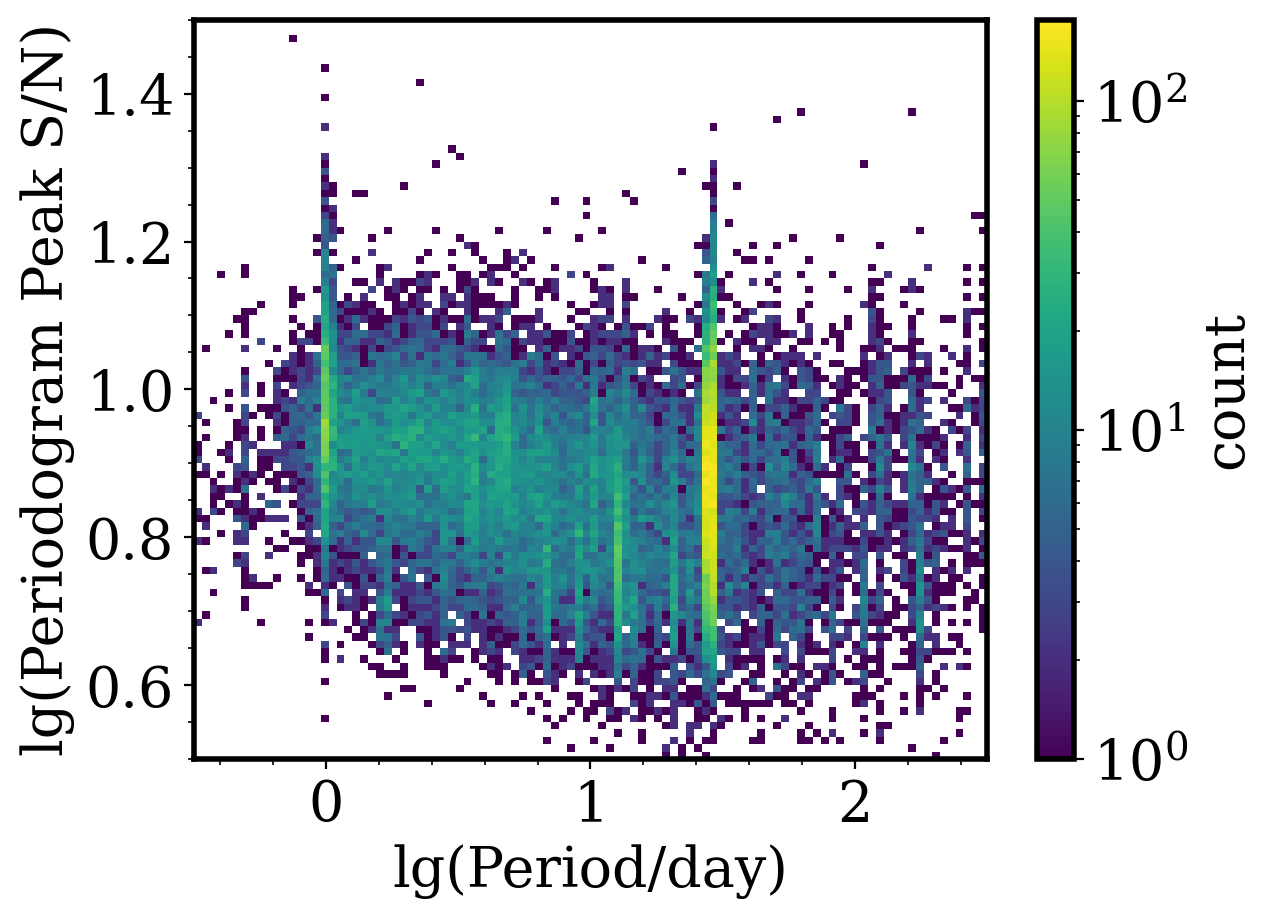

In [17]:
lg_period_bins = np.linspace(-0.5, 2.5, 101)
lg_snr_bins = np.linspace(0.5, 1.5, 101)
plt.hist2d(
    np.log10(features_computed["period_0"]),
    np.log10(features_computed["period_s_to_n_0"]),
    bins=[lg_period_bins, lg_snr_bins],
    norm=LogNorm(),
)
plt.colorbar(label="count")
plt.xlabel('lg(Period/day)')
plt.ylabel('lg(Periodogram Peak S/N)')
plt.minorticks_on()

Below is the ZTF periodogram where also observe the aliasing sampling periods. For more information about periodograms please have a look at the [references](#References) section of this notebook.

![ZTF periodogram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/ztf-periodogram.jpg)

## Plot light curve

We can now find a ZTF object with a high period SNR and that is bright, and plot the ZTF-r band light curve.

In [18]:
# Select good SNR candidate
# Filter out bogus periods
good_periods = features_computed.query(
    "period_0 < 400"  # large periods are likely to be bogus, e.g. about of duration of light curve
    " and not(29 < period_0 < 30)"  # lunar month
    " and not(0.95 < period_0 < 1.05)"  # day
)
# Select bright stars with highest S/N of the peridogram peak
top5 = good_periods.sort_values('period_s_to_n_0').tail(5)
top5

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources,nobs,period_0,period_s_to_n_0,weighted_mean,eta,excess_variance,amplitude
_healpix_29,,,,,,,,,,,,,,,
304020453909162392,132.369357,12.630025,123151323693776471,132.369366,12.629995,0.997652,0.114896,ra dec mjd ...,611,51.210102,23.021568,17.608391,1.200382,2.604891e-06,0.122932
302555262975239951,133.427161,12.554946,123061334272106381,133.427181,12.554904,0.457355,0.166037,ra dec mjd ...,578,61.499851,23.475756,19.338057,1.569203,6.907491e-06,0.478012
299372020469511980,132.155241,10.782379,120931321552409318,132.155245,10.782355,0.051167,0.088267,ra dec mjd ...,585,162.645767,23.511620,15.835193,0.045749,1.328978e-03,1.412745
299383603020712620,131.836029,11.062713,121271318360275742,131.836029,11.062688,0.212047,0.092564,ra dec mjd ...,566,2.209234,26.212900,17.610193,1.287198,7.539421e-06,0.170574
301026083017518503,131.677039,12.31564,122771316770509238,131.677051,12.315603,0.30964,0.142529,ra dec mjd ...,570,0.724741,29.706047,15.488962,1.652508,8.340544e-07,0.063979


In [19]:
# Select a light curve with high SNR
i = 4
best_period = top5['period_0'].iloc[i]  # (in days) best period from the above table
lc = top5['sources'].iloc[i]
lc

,ra,dec,mjd,mag,magerr,band,catflags
0,131.677039,12.31564,59196.38358,15.490785,0.012778,r,0
1,131.677039,12.31564,59221.27017,15.519132,0.012804,r,0
2,131.677039,12.31564,59150.52629,15.475466,0.012765,r,0
3,131.677039,12.31564,59152.48175,15.500073,0.012787,r,0
4,131.677039,12.31564,59155.49781,15.516324,0.012802,r,0
...,...,...,...,...,...,...,...
565,131.677039,12.31564,59697.17633,15.467032,0.012758,r,0
566,131.677039,12.31564,59701.20130,15.502284,0.012789,r,0
567,131.677039,12.31564,59290.24002,15.496457,0.012783,r,0
568,131.677039,12.31564,59336.20541,15.466855,0.012758,r,0


When we fold the light curve on the correct period the scatter between the points is minimized, and therefore, the observations line up.

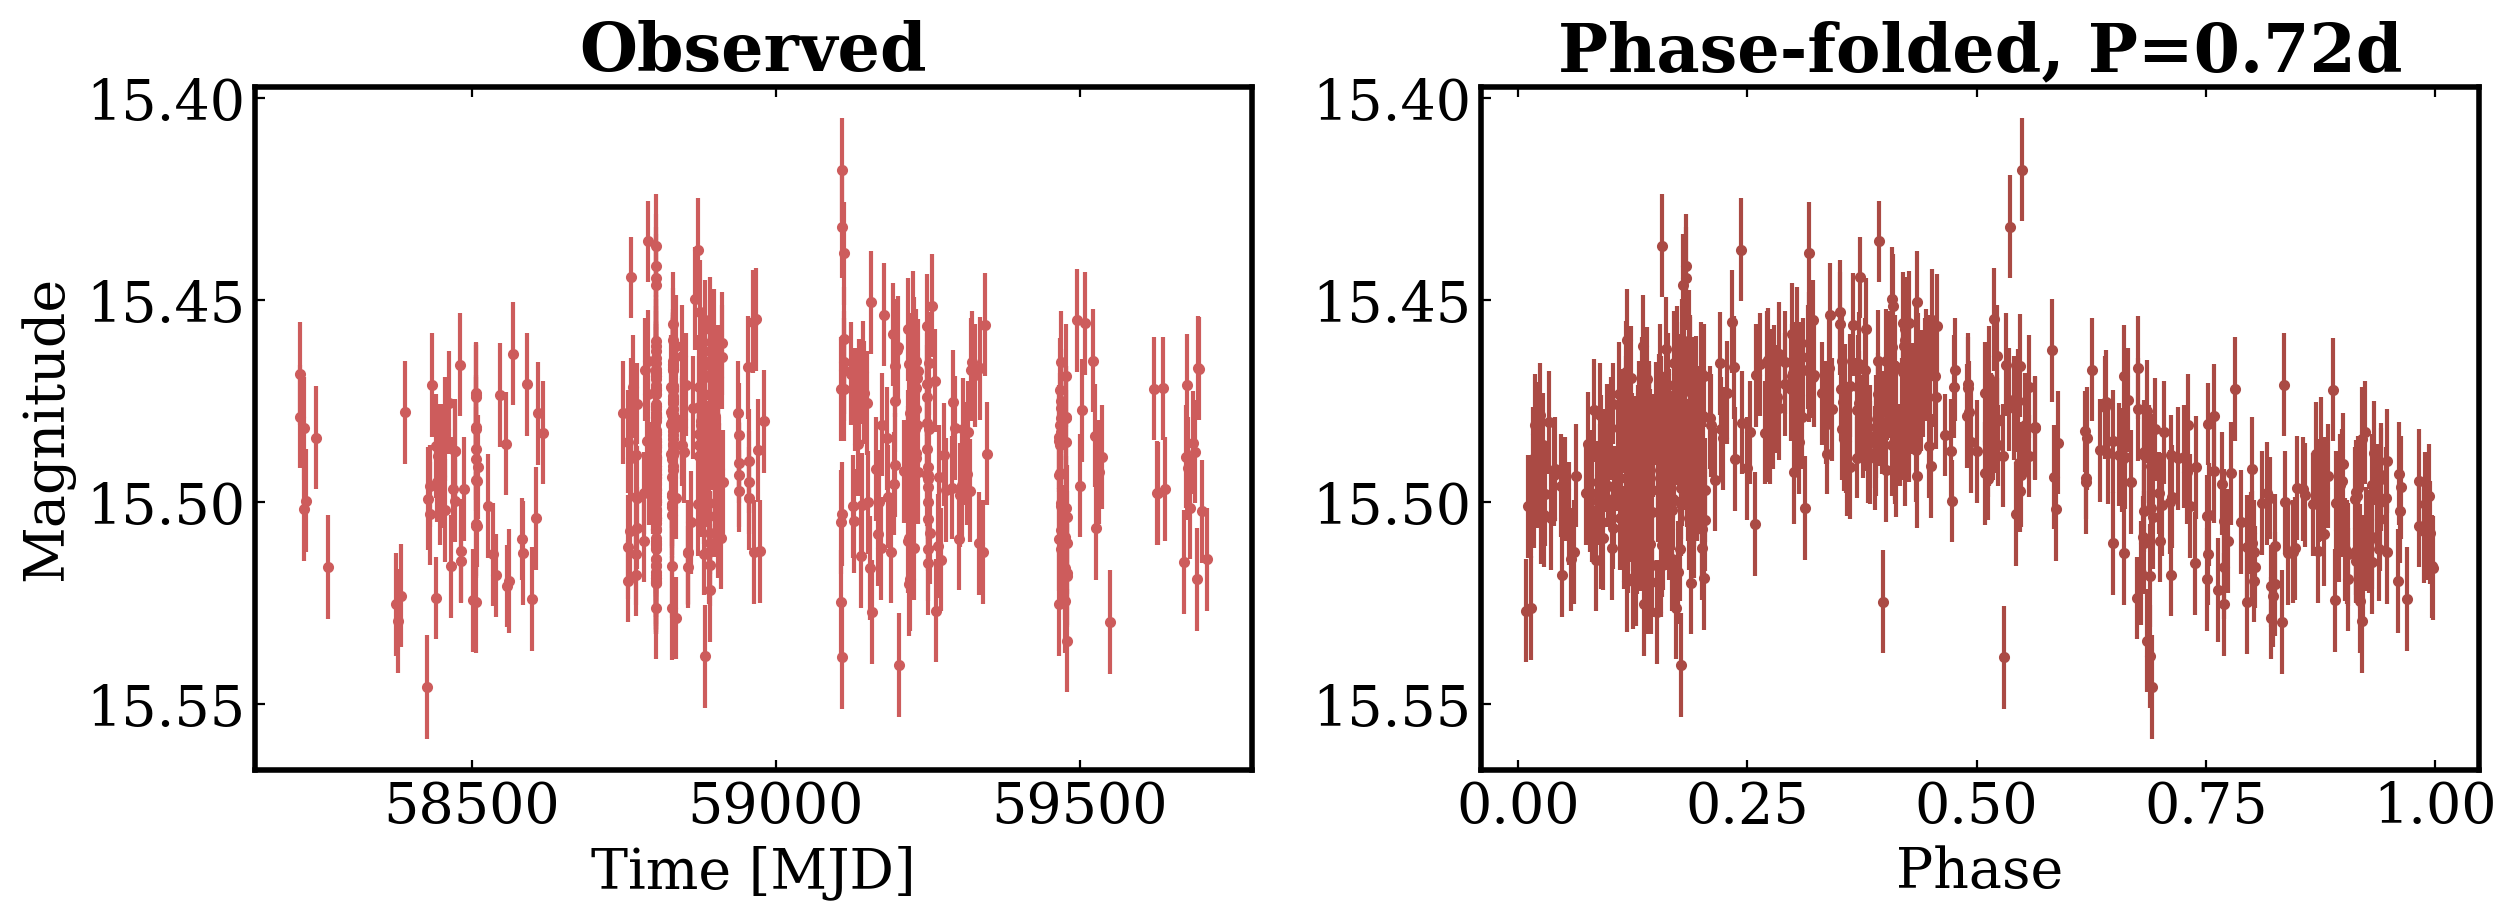

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].errorbar(
    lc["mjd"],
    lc["mag"],
    yerr=lc["magerr"], 
    fmt='.',
    color='indianred'
)

ax[1].errorbar((lc["mjd"].to_numpy()%best_period)/best_period, lc["mag"],
                yerr=lc["magerr"], fmt='.', color='#AA4A44')
ax[1].set_xlabel('Phase')
ax[0].set_xlabel('Time [MJD]')
ax[1].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[1].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Observed", weight='bold')
ax[1].set_title(f"Phase-folded, P={best_period:.2f}d", weight='bold')

plt.tight_layout()

## Extra topics

### Existing feature extractors

In this notebook we demonstrated how you can define and use your own custom functions to operate on light curves. There are also third-party packages that extract common features so that you don't have to implement these operations yourself (e.g. [`light-curve`](https://github.com/light-curve/light-curve-python) package). For more information please read the following [tutorial](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html#Extract-features-from-ZTF-light-curves).

### Example of very large analysis

This is an example of a similar analysis as above, but on the entire ZTF DR14 dataset, extracting periods from ~billion light curves. The computation took 90 minutes on the Pittsburgh Supercomputer Center resourcees. We used a 256GB manager node and 50 × 32GB workers (3 threads per worker) allocated as a 50 SLURM jobs.

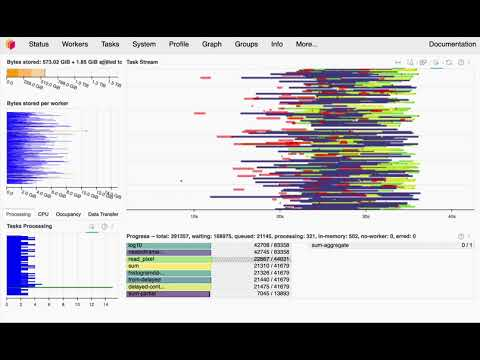

In [21]:
from IPython.display import YouTubeVideo

YouTubeVideo('04lGbtNTzZw', width=800, height=450)

#### Close the DASK client

In [22]:
# Release allocated resources!
client.close()

### References

[1]: https://iopscience.iop.org/article/10.3847/1538-4365/aab766 \
[2]: https://academic.oup.com/mnras/article/505/2/2954/6284767 \
[3]: https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html \
[4]: Science with ZTF: https://iopscience.iop.org/article/10.1088/1538-3873/ab006c/pdf \
[5]: https://www.youtube.com/watch?v=2EwtD3Nhazs